In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits

In [6]:
data = ('../data/Observing Project/raw_data/ngc7789_b_30_1.fit')
image_data = fits.getdata(data)
image_hdr  = fits.getheader(data)
image_data

array([[1219, 1208, 1247, ..., 1421, 1663, 2005],
       [1186, 1209, 1231, ..., 1227, 1350, 1405],
       [1218, 1189, 1187, ..., 1201, 1261, 1303],
       ..., 
       [1196, 1209, 1249, ..., 1190, 1179, 1185],
       [1208, 1240, 1222, ..., 1174, 1148, 1154],
       [1211, 1220, 1209, ..., 1189, 1149, 1201]], dtype=uint16)

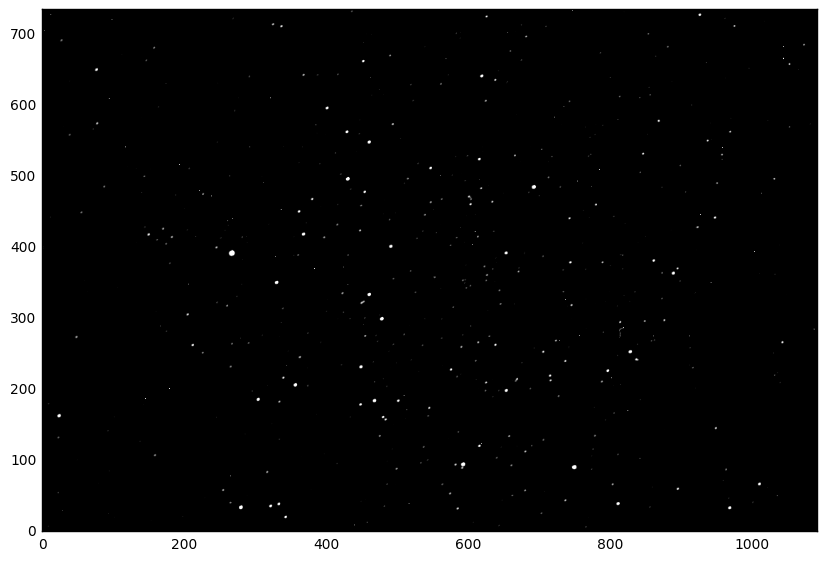

In [7]:
fig, axis = plt.subplots(figsize=(10,10))
implot = axis.imshow(image_data,cmap='gray',origin='lower',vmin=1500,vmax=2500)
axis.grid(False)
plt.show()

In [8]:
print( image_hdr['EXPOSURE'] )

30.0


In [9]:
hdu  = fits.PrimaryHDU(data=image_data, header=image_hdr)
hdu.writeto('my_new_fits_file.fits',clobber=True)

In [10]:
import ccdproc # the ccdproc library
from reduction_tools import Combiner, Reduction # Stu's custom tools for combining and `reducing` CCD data.

In [11]:
data_dir = '../data/Observing Project/raw_data'
destination_dir = '../data/Observing Project/calib_data'

import os
#make destination directory if it does not exist
if not os.path.exists(destination_dir):
    os.mkdir(destination_dir)

In [12]:
images = ccdproc.ImageFileCollection(location=data_dir, keywords=['imagetyp', 'exposure', 'filter'])
print(images.summary_info)

        file        imagetyp exposure filter
------------------- -------- -------- ------
         bias_1.fit     BIAS      0.0     --
         bias_2.fit     BIAS      0.0     --
         bias_3.fit     BIAS      0.0     --
     dark_300_1.fit     DARK    300.0     --
     dark_300_2.fit     DARK    300.0     --
     dark_300_3.fit     DARK    300.0     --
      dark_30_1.fit     DARK     30.0     --
      dark_30_2.fit     DARK     30.0     --
      dark_30_3.fit     DARK     30.0     --
       flat_b_1.fit     FLAT      7.0      B
                ...      ...      ...    ...
ngc7789_b_300_2.fit    LIGHT    300.0      B
ngc7789_b_300_3.fit    LIGHT    300.0      B
 ngc7789_b_30_1.fit    LIGHT     30.0      B
 ngc7789_b_30_2.fit    LIGHT     30.0      B
 ngc7789_b_30_3.fit    LIGHT     30.0      B
ngc7789_v_300_1.fit    LIGHT    300.0      V
ngc7789_v_300_2.fit    LIGHT    300.0      V
ngc7789_v_300_3.fit    LIGHT    300.0      V
 ngc7789_v_30_1.fit    LIGHT     30.0      V
 ngc7789_v

In [13]:
#changes headers
from astropy.io import fits
hdu_list = fits.open('../data/Observing Project/raw_data/ngc7789_v_30_3.fit',mode='update')
data = hdu_list[0].data
header = hdu_list[0].header

print(header['IMAGETYP'])
header['IMAGETYP'] = "LIGHT"

LIGHT


In [14]:
hdu_list.flush()

In [15]:
# define the Reduction task
copy_file_task = Reduction(input_image_collection=images, 
                           destination=destination_dir, 
                           apply_to={'imagetyp': 'BIAS'},
                           copy_only=True)

# the line above simply creates the Reduction task object. To run it, call it's `action` function, like so
copy_file_task.action()

ERROR:ccdproc.image_collection:error writing file ../data/Observing Project/calib_data/bias_1.fit


One or more of the reduced images already exists. Delete those files and try again. This class will NOT overwrite existing files.


In [16]:
reduced_images = ccdproc.ImageFileCollection(location=destination_dir, keywords=['imagetyp', 'exposure', 'filter', 'master'])

make_master_bias = Combiner(image_source=reduced_images,
                            file_name_base='master_bias',
                            combine_method='average',
                            apply_to={'imagetyp':'BIAS'},
                            destination=destination_dir)
make_master_bias.action()

OSError: File '../data/Observing Project/calib_data/master_bias.fit' already exists.

In [ ]:
os.listdir(destination_dir)

In [ ]:
# use os library to glue directories and filenames together easily
filepath = os.path.join(destination_dir, 'master_bias.fit')
print(filepath)

# open the file and store data in array called 'masterbias'
masterbias = fits.getdata(filepath)

# What's the mean level in the bias image?
print('The masterbias has mean level of {:.1f} counts'.format( masterbias.mean() ))

# display it
fig, axis = plt.subplots(figsize=(5,5))
# custom scaling - see companion notebook
vmin,vmax = np.percentile(masterbias, [1,99])
implot = axis.imshow(masterbias,cmap='gray',origin='lower',vmin=vmin,vmax=vmax)
axis.grid(False)
plt.show()

In [17]:
#It is best to combine the dark frames using the median, rather than the mean. Dark frames are often long exposures, which can be affected by cosmic rays. 
#Cosmic rays hitting the CCD will excite also excite electrons. Taking the median of the master dark will help remove cosmic rays from the master dark frame.

In [18]:
dark_preprocessing = Reduction(bias_subtract=True,
                               dark_subtract=False,
                               flat_correct=False,
                               master_source=reduced_images,
                               input_image_collection=images,
                               destination=destination_dir,
                               apply_to={'imagetyp': 'dark'})
dark_preprocessing.action()

ERROR:ccdproc.image_collection:error writing file ../data/Observing Project/calib_data/dark_300_1.fit


One or more of the reduced images already exists. Delete those files and try again. This class will NOT overwrite existing files.


In [19]:
#make a master dark

In [20]:
make_master_dark = Combiner(file_name_base='master_dark',
                            combine_method='median',
                            image_source=reduced_images,
                            apply_to={'imagetyp':'DARK'},
                            group_by='exposure',
                            destination=destination_dir)
make_master_dark.action()

OSError: File '../data/Observing Project/calib_data/master_dark_exposure_30.0.fit' already exists.

In [ ]:
os.listdir(destination_dir)

In [ ]:
filepath = os.path.join(destination_dir,"master_dark_exposure_300.0.fit")

masterdark_im = fits.getdata(filepath)

# What's the mean level in the dark image?
print('The masterdark has mean level of {:.1f} counts'.format( masterdark_im.mean() ))

# display it
fig, axis = plt.subplots(figsize=(5,5))
# custom scaling - see companion notebook
vmin,vmax = np.percentile(masterdark_im, [1,99])
implot = axis.imshow(masterdark_im,cmap='gray',origin='lower',vmin=vmin,vmax=vmax)
axis.grid(False)
plt.show()

In [21]:
dark_fits_filename = os.path.join(destination_dir, 'dark_300_1.fit') # use os.path.join to glue together directory and filename
img_hdr = fits.getheader(dark_fits_filename) # read in FITS header using astropy's fits library
print(img_hdr['EXPOSURE'])

300.0


In [22]:
#process flats
flat_reduction = Reduction(bias_subtract=True,
                           dark_subtract=False,
                           flat_correct=False,
                           master_source=reduced_images,
                           input_image_collection=images,
                           destination=destination_dir,
                           apply_to={'imagetyp':'FLAT'})
flat_reduction.action()

ERROR:ccdproc.image_collection:error writing file ../data/Observing Project/calib_data/flat_b_1.fit


One or more of the reduced images already exists. Delete those files and try again. This class will NOT overwrite existing files.


In [23]:
#create master flat
make_master_flat = Combiner(file_name_base='master_flat',
                            group_by='filter',
                            image_source=reduced_images,
                            destination=destination_dir,
                            apply_to={'imagetyp':'FLAT'})
make_master_flat.action()

OSError: File '../data/Observing Project/calib_data/master_flat_filter_B.fit' already exists.

In [ ]:
#plot master flat
filepath = os.path.join(destination_dir,"master_flat_filter_V.fit")

masterflat_im = fits.getdata(filepath)

# What's the mean level in the dark image?
print('The masterflat has mean level of {:.1f} counts'.format( masterflat_im.mean() ))

# display it
fig, axis = plt.subplots(figsize=(6,6))
# custom scaling - see companion notebook
vmin,vmax = np.percentile(masterflat_im, [1,99])
implot = axis.imshow(masterflat_im,cmap='gray',origin='lower',vmin=vmin,vmax=vmax)
axis.grid(False)
plt.show()

In [24]:
#subtract master bias
#subtract master dark
#divide by master flat
#save calib image
data_reduction = Reduction(bias_subtract=True,
                           dark_subtract=True,
                           flat_correct=True,
                           master_source=reduced_images,
                           input_image_collection=images,
                           destination=destination_dir,
                           apply_to={'imagetyp':'LIGHT'})
data_reduction.action()

ERROR:ccdproc.image_collection:error writing file ../data/Observing Project/calib_data/ngc7789_b_300_1.fit


One or more of the reduced images already exists. Delete those files and try again. This class will NOT overwrite existing files.


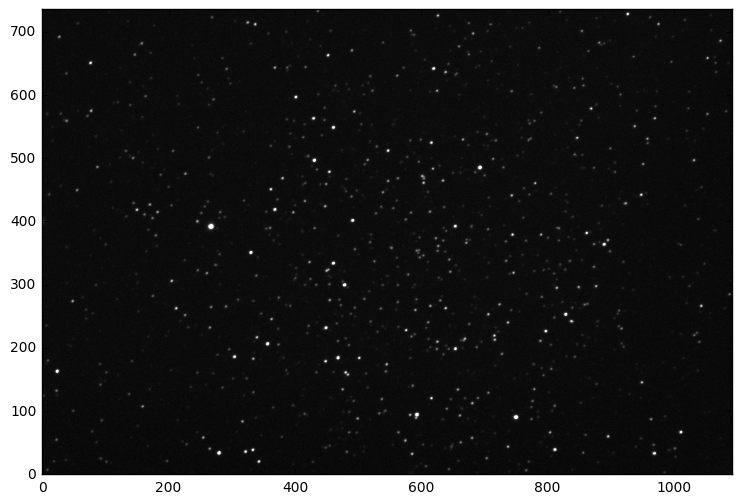

In [29]:
image_filepath=os.path.join(destination_dir, "MED_b_30_aligned.fits")
m51_image=fits.getdata(image_filepath)

fig, axis = plt.subplots(figsize=(15,6))
implot = axis.imshow(m51_image,cmap='gray',origin='lower',vmin=200,vmax=1500)
axis.grid(False)
plt.show()